dataset heart failure prediction https://www.kaggle.com/fedesoriano/heart-failure-prediction

In [1]:
import pandas as pd
import numpy as np
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv("heart.csv")
print(df.shape)
df.head(3)

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


11 признаков

In [2]:
features = ["Age", "Sex", "ChestPainType", "Cholesterol", "RestingBP", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina",
           "Oldpeak", "ST_Slope"]
target = "HeartDisease"

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42)

In [3]:
X_train.describe()

,Age,Cholesterol,RestingBP,FastingBS,MaxHR,Oldpeak
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,53.754360,201.636628,133.077035,0.220930,136.194767,0.915552
std,9.391337,107.445888,18.532591,0.415175,25.042552,1.097611
min,29.000000,0.000000,0.000000,0.000000,63.000000,-2.600000
25%,47.000000,179.750000,120.000000,0.000000,118.000000,0.000000
50%,54.000000,224.000000,130.000000,0.000000,138.000000,0.600000
75%,60.000000,270.000000,140.000000,0.000000,155.000000,1.600000
max,77.000000,603.000000,200.000000,1.000000,192.000000,6.200000


In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
cont_cols = ["Age",  "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
cat_cols = ["ChestPainType", "Sex", "RestingECG", "ExerciseAngina", "ST_Slope"]
base_cols = ["FastingBS"]


cont_transformers = []
cat_transformers = []
base_transformers = []

final_transformers = list()


for cont_col in cont_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    final_transformers.append((base_col, base_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [5]:
boost = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier()),
])

In [6]:
boost.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('RestingBP',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='RestingBP')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('Cholesterol',
                                                 Pipeline(steps=[('selector',
                             

In [7]:
y_score = boost.predict_proba(X_test)[:, 1]

In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b=1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Linear Regression Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

precision, recall, fscore = precision[ix], recall[ix], fscore[ix]

Linear Regression Best Threshold=0.376573, F-Score=0.924, Precision=0.924, Recall=0.924


ооочень хорошие показатели :) скорее всего модель переобучена

In [9]:
#intercept = boost[1].intercept_
#features = pd.DataFrame(boost[1].coef_, 
                        #cont, 
                        #columns=['coefficient'])
#features.head()

На Бустинге не могу использовать intercept, так как этот инструмент для линейной регрессии(или для continuous features). Попробую использовать permutation

In [20]:
final_transformers

[('Age',
  Pipeline(steps=[('selector', NumberSelector(key='Age')),
                  ('standard', StandardScaler())])),
 ('RestingBP',
  Pipeline(steps=[('selector', NumberSelector(key='RestingBP')),
                  ('standard', StandardScaler())])),
 ('Cholesterol',
  Pipeline(steps=[('selector', NumberSelector(key='Cholesterol')),
                  ('standard', StandardScaler())])),
 ('MaxHR',
  Pipeline(steps=[('selector', NumberSelector(key='MaxHR')),
                  ('standard', StandardScaler())])),
 ('Oldpeak',
  Pipeline(steps=[('selector', NumberSelector(key='Oldpeak')),
                  ('standard', StandardScaler())])),
 ('ChestPainType',
  Pipeline(steps=[('selector', ColumnSelector(key='ChestPainType')),
                  ('ohe', OHEEncoder(key='ChestPainType'))])),
 ('Sex',
  Pipeline(steps=[('selector', ColumnSelector(key='Sex')),
                  ('ohe', OHEEncoder(key='Sex'))])),
 ('RestingECG',
  Pipeline(steps=[('selector', ColumnSelector(key='RestingECG')),
 

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

predictions =  boost.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.13043478260869565, 0.46660482374768086)

MAE если актуально (в чем я сомневаюсь) - маленький, а вот R2 мог бы быть и получше. 

In [11]:
cont = cont_cols + cat_cols + base_cols
cont

['Age',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ChestPainType',
 'Sex',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'FastingBS']

In [18]:
boost[0]

FeatureUnion(transformer_list=[('Age',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='Age')),
                                                ('standard',
                                                 StandardScaler())])),
                               ('RestingBP',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='RestingBP')),
                                                ('standard',
                                                 StandardScaler())])),
                               ('Cholesterol',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='Cholesterol')),
                                                ('standard',
                                                 StandardScaler())])),
                               ('MaxH...
    

In [19]:
fi = boost[1].feature_importances_
fi

array([0.03619629, 0.03155423, 0.07682464, 0.05069433, 0.09162561,
       0.08212644, 0.00305757, 0.00467694, 0.00167553, 0.02572297,
       0.02009467, 0.00314583, 0.        , 0.00260551, 0.03737598,
       0.02575616, 0.00367085, 0.02374217, 0.45715734, 0.02229694])

In [12]:
boost_features = pd.DataFrame(boost[1].feature_importances_, 
                        cont,
                        columns=['coefficient'])
boost_features.head()

ValueError: Shape of passed values is (20, 1), indices imply (11, 1)

ОШИБКА. Не понимаю, откуда появляются 20 фичей ((( у меня их всего 11.  

In [21]:
from sklearn.inspection import permutation_importance
r = permutation_importance(boost, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

In [22]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{cont[i]:<20} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

FastingBS            0.136 +/- 0.015
Cholesterol          0.037 +/- 0.012
MaxHR                0.030 +/- 0.011
ChestPainType        0.018 +/- 0.007
RestingBP            0.013 +/- 0.007
RestingECG           0.006 +/- 0.011
ST_Slope             0.004 +/- 0.013
Sex                  0.003 +/- 0.004
ExerciseAngina       0.001 +/- 0.007
Oldpeak              -0.003 +/- 0.007
Age                  -0.009 +/- 0.007


Судя по результатм - важный фактор - Fasting BS (fasting blood sugar), Холестерол, MaxHR (maximum heart rate achieved)

In [23]:
#pip install shap

You should consider upgrading via the '/Users/zett/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [26]:
import xgboost as xgb

In [32]:
features = cont_cols

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[cont_cols], df[target], random_state=42)

In [34]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

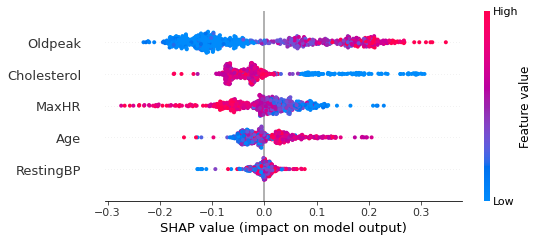

In [35]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

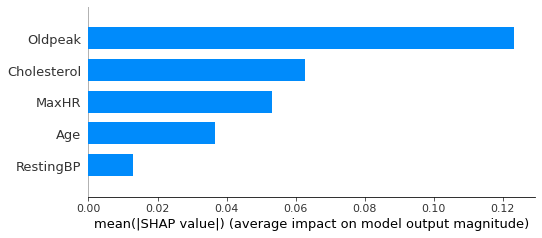

In [36]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Cудя по этим данным - Oldpeak и Холестерол влияют критически на модель. Но ранее oldpeak  никак себя не проявил. 

Из чего я делаю выводы, что мои расчеты не очень верны)

И еще не очень понимаю - shap не работает на категориальных признаках? Или это я сама себя загнала в ловушку?

Попробую также обучить на тестовых данных? 

In [39]:
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

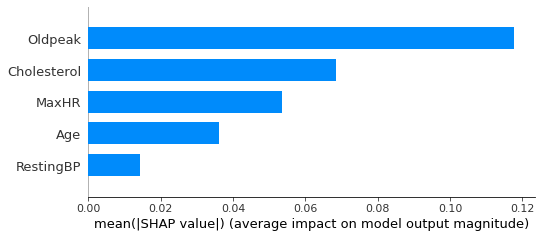

In [40]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

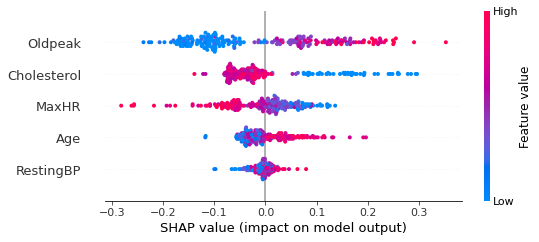

In [41]:
shap.summary_plot(shap_values, X_test)